# 02 Plotting Candlestick chart.

* **Reference**: https://plotly.com/python/candlestick-charts
* **Reference2**: https://chancoding.tistory.com/116?category=846070 [Endian] [2020] 
* **Final Edit**: 2021-08-03

In [1]:
!pip3 install --user pandas
!pip3 install --user html5lib
!pip3 install --user BeautifulSoup4
!pip3 install --user plotly
!pip3 install --user nbformat
!pip3 install --user mplfinance

In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}

def get_url(item_name, code_df): 
  code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
  url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
  print("요청 URL = {}".format(url)) 
  return url

def get_html_table_symbol(url):
  response = requests.get(url, headers=headers)
  html = bs(response.text, 'lxml')
  html_table = html.select('table')
  len(html_table)
  return str(html_table)

# 1: Get event_code from 상장법인목록.xls
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

# 2. Get stock data from naver finance
item_name='삼성전자' 
url = get_url(item_name, code_df)

df = pd.DataFrame()
for page in range(1, 21):
  pg_url = '{url}&page={page}'.format(url=url, page=page)
  table = get_html_table_symbol(pg_url)
  df = df.append(pd.read_html(table, header=0)[0], ignore_index=True)
df = df.dropna()

# 3. Rename columns
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
df['date'] = pd.to_datetime(df['date']) 
df = df.sort_values(by=['date'], ascending=True) 


요청 URL = http://finance.naver.com/item/sise_day.nhn?code=005930


# 1. Plotly 사용

In [4]:
import plotly.offline as offline 
import plotly.graph_objs as go 
from datetime import datetime

offline.init_notebook_mode(connected=True) 

trace = go.Candlestick(x=df.date, 
                        open=df.open,
                        high=df.high, 
                        low=df.low, 
                        close=df.close,
                        increasing_line_color= 'red', 
                        decreasing_line_color= 'blue'
                        ) 

data = [trace] 

layout = go.Layout(title='삼성전자')

fig = go.Figure(data=data, layout=layout) 
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]),
        #dict(values=["2020-12-25", "2021-01-01"])
    ]
)

fig.update_layout(xaxis_rangeslider_visible=False)
offline.iplot(fig, filename="candlestick")


# 2.candlestick2_ohlc + pyplot 사용

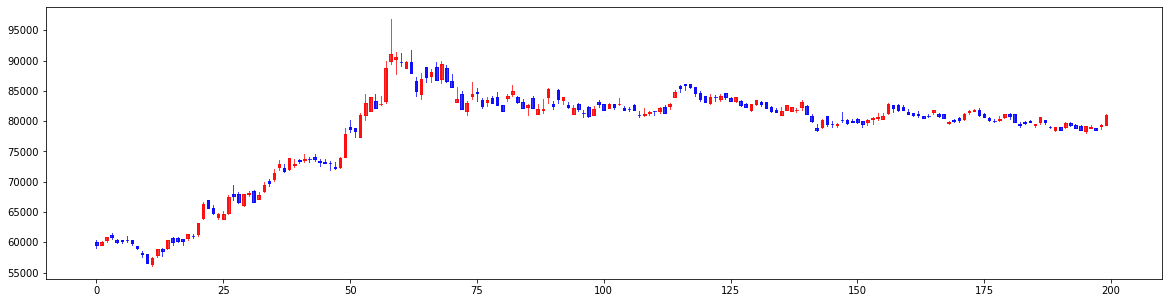

In [5]:
import datetime
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)

candlestick2_ohlc(ax, df['open'],df['high'],df['low'], df['close'], width=0.5, colorup='r', colordown='b')
plt.show()
